About project:
We try to predict loan_status of each person based on our data. "loan status" = 1 means that the person has not repaid his debt, "loan status" = 0 - that he has repaid. The goal is to effectively identify unreliable borrowers.

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from functions import visualize_barplot_2

We define functions to quick score our improvements:

In [223]:
def print_scores(y_true, y_pred, average = "binary", pos_label = 1):
    print("Accuracy : ", accuracy_score(y_true, y_pred))
    print("Recall   : ", recall_score(y_true, y_pred,average=average, pos_label=pos_label))
    print("Precision: ", precision_score(y_true, y_pred, average=average, pos_label=pos_label))
    print("F1_score: ", f1_score(y_true, y_pred, average=average, pos_label=pos_label))

def score(X_train, y_train, X_test, y_test):
    if checking == True:
        #clf = SVC(class_weight='balanced',probability=True)
        clf = LogisticRegression(class_weight='balanced')
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        print("Class 0")
        print_scores(y_test,pred,pos_label=0)
        print("Class 1")
        print_scores(y_test, pred, pos_label=1)
        print("Roc auc score:")
        print(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
        return confusion_matrix(y_test,pred)
    else:
        print("function power off")

Loading data:

In [252]:
checking = True
data = pd.read_csv("train.csv",index_col=0)
print(data.columns)
print(data.head())
print(data.describe().T)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')
    person_age  person_income person_home_ownership  person_emp_length  \
id                                                                       
0           37          35000                  RENT                0.0   
1           22          56000                   OWN                6.0   
2           29          28800                   OWN                8.0   
3           30          70000                  RENT               14.0   
4           22          60000                  RENT                2.0   

   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                         
0    EDUCATION          B       6000         

After train test split we will try to remove outliers in features 'person_income' and 'person_age'

How many persons in each class we have?

In [226]:
print(data['loan_status'].value_counts())

loan_status
0    50295
1     8350
Name: count, dtype: int64


Be careful - classes are imbalanced. Because of that we will use roc auc score.

What type of data we need to deal with?

In [227]:
object_columns = data.select_dtypes(include=['object'])
for col in object_columns:
    unique_values = data[col].unique()
    print(f"Column: {col}, unique values: {unique_values}")

columns_2_unq = [col for col in object_columns if data[col].nunique() == 2]
columns_more_than_2_unq = [col for col in object_columns if data[col].nunique() > 2]
num_columns = [col for col in data.columns if col not in object_columns]

Column: person_home_ownership, unique values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Column: loan_intent, unique values: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
Column: loan_grade, unique values: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
Column: cb_person_default_on_file, unique values: ['N' 'Y']


So nice non-numeric data ;) Let's explore something about it:

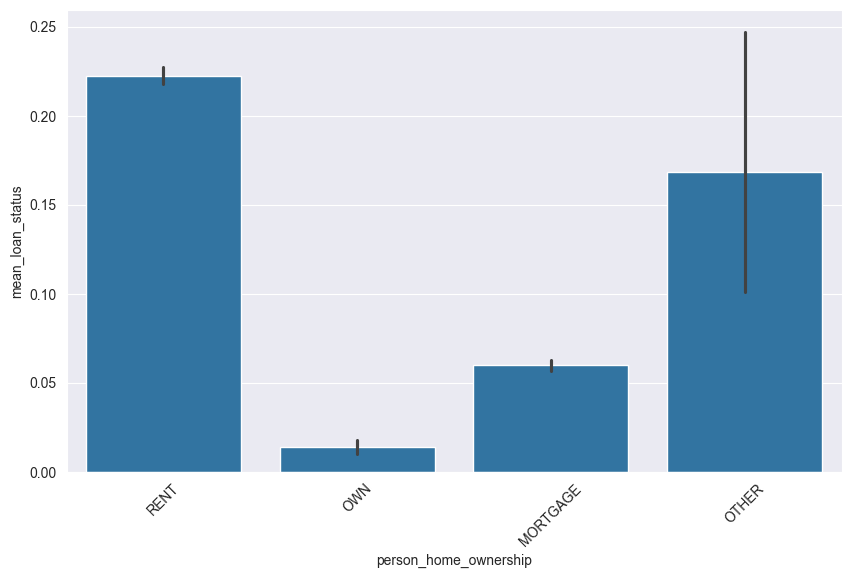

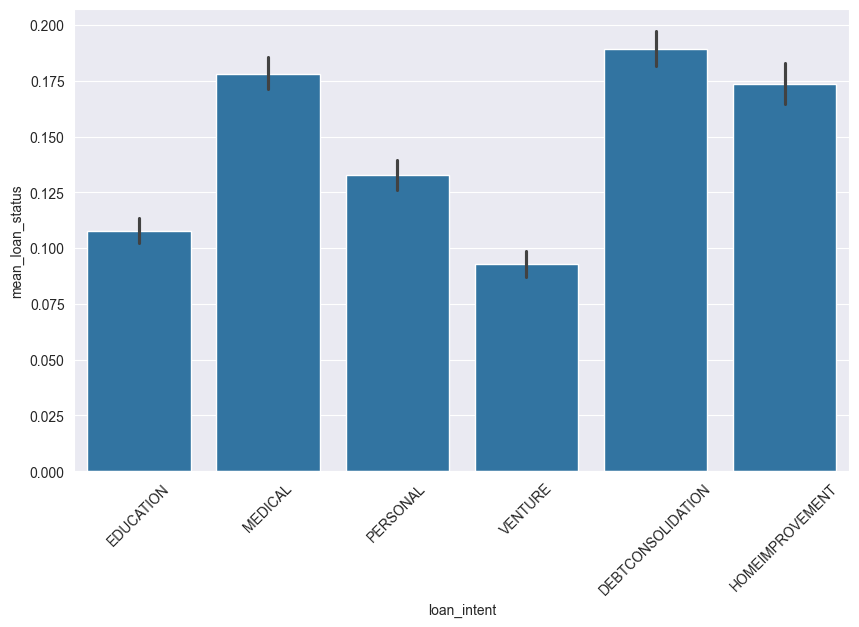

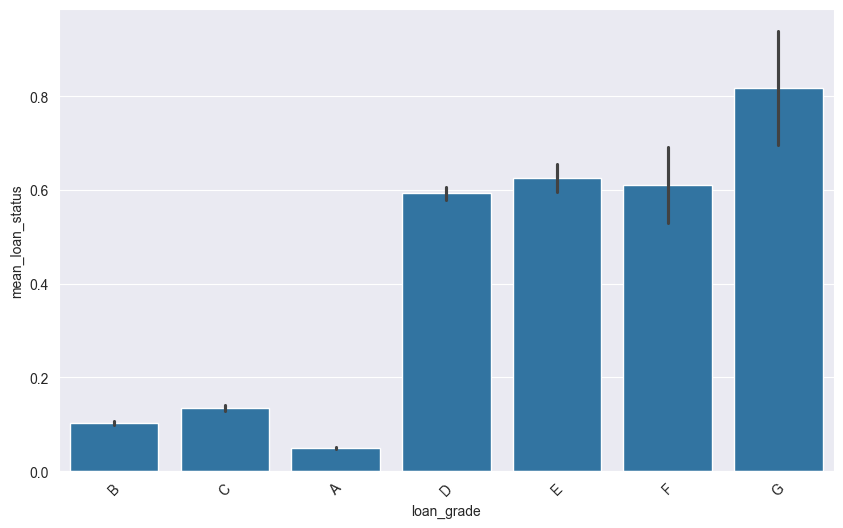

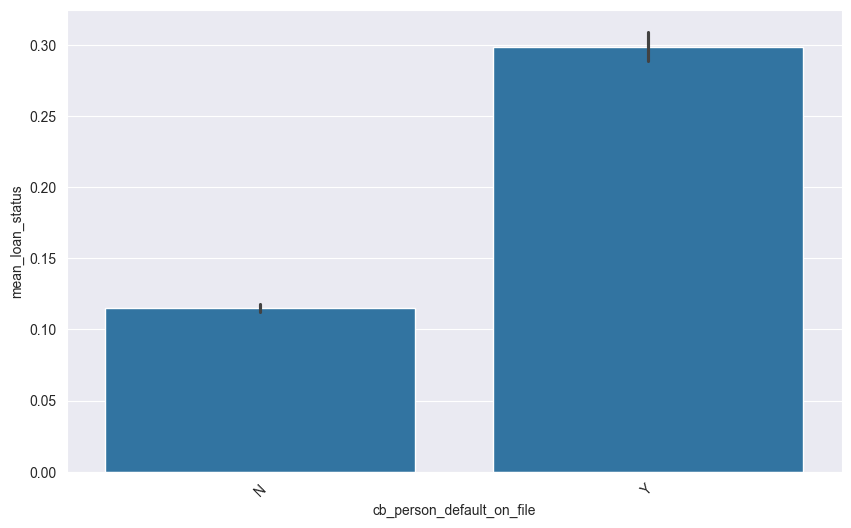

In [228]:
from functions import visualize_barplot
for col in object_columns:
    visualize_barplot(col,data)

Take look to numerical data:

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


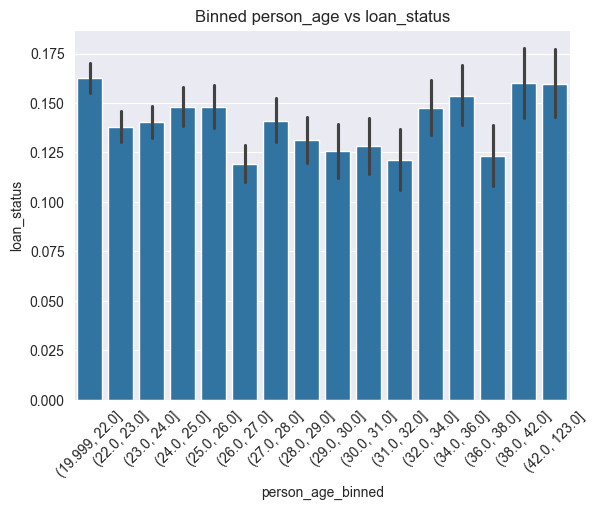

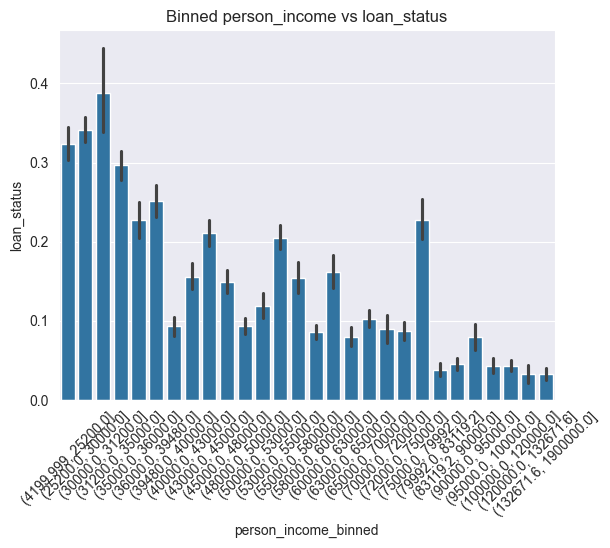

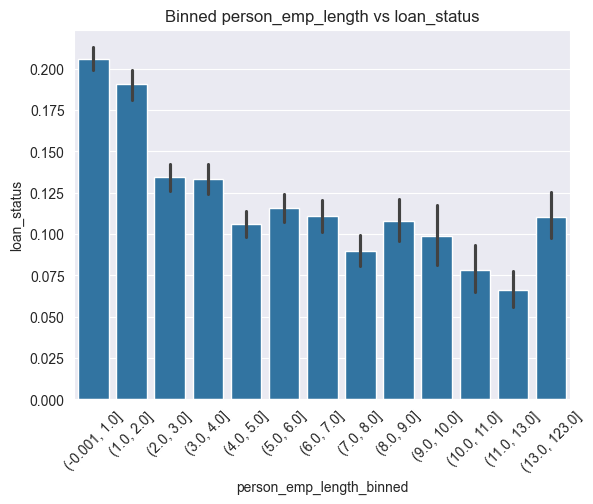

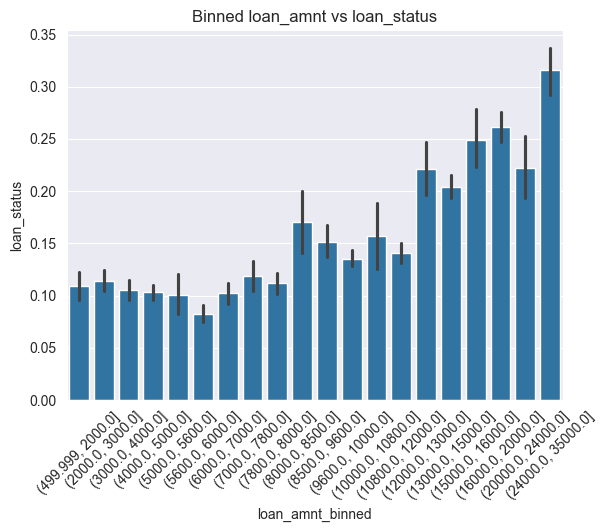

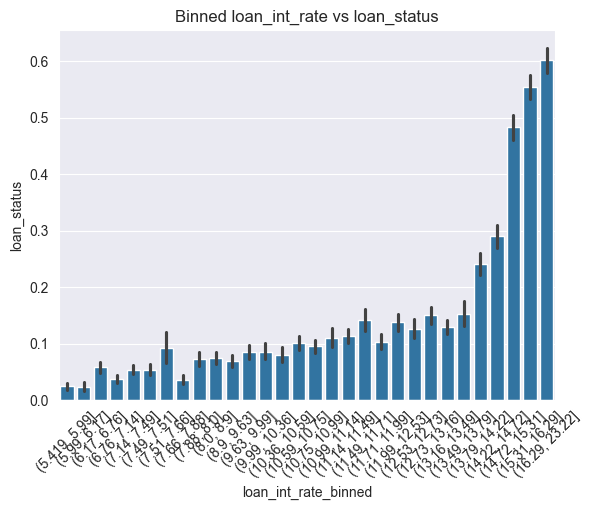

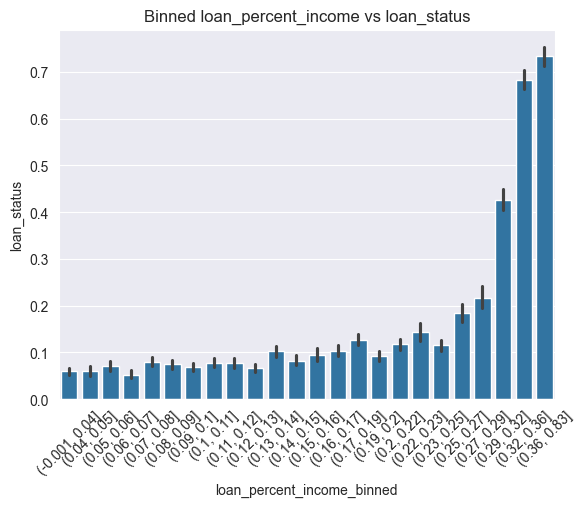

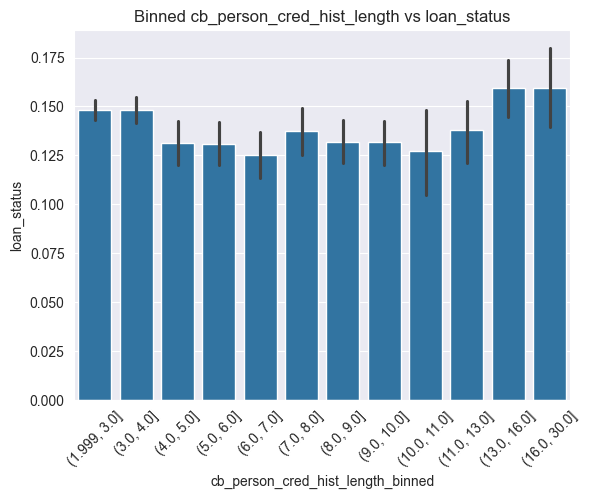

In [229]:
num_columns = [i for i in num_columns if i !='loan_status']
print(num_columns)
visualize_barplot_2(num_columns,data)

Interesting for us are loan_percent_income and loan_int rate. Rest of columns are messy or linear in relation to loan_status. Let's try to fix it:

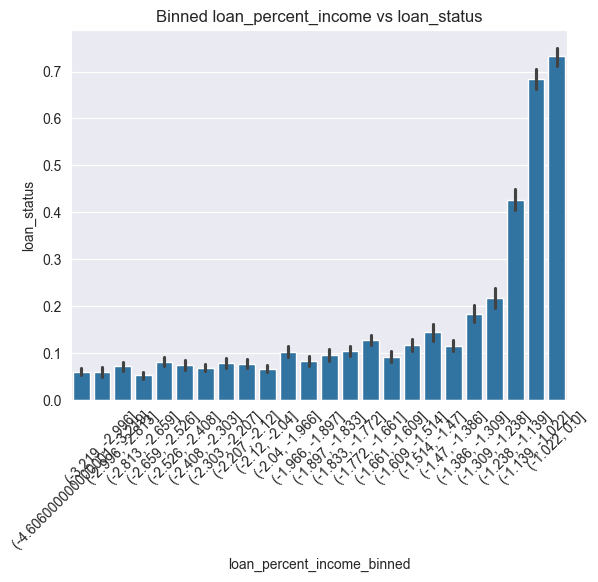

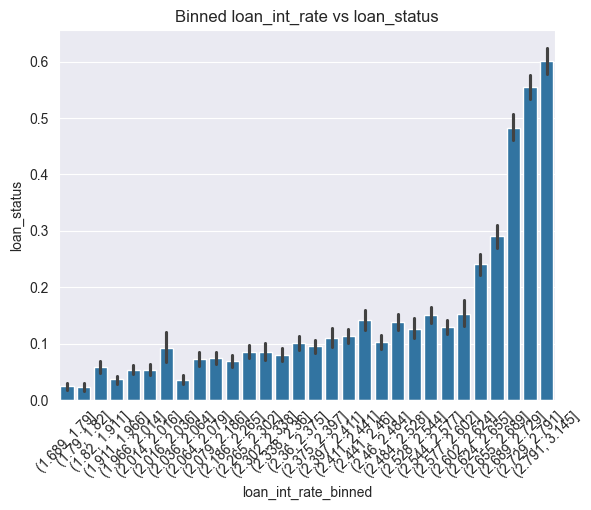

In [230]:
changed_columns = ['loan_percent_income','loan_int_rate']

data['loan_percent_income']=data['loan_percent_income'].map(lambda x: np.log(x) if x!=0 else 0)
data['loan_int_rate']=data['loan_int_rate'].map(lambda x: np.log(x) if x!=0 else 0)

visualize_barplot_2(changed_columns,data)

Creating some features:

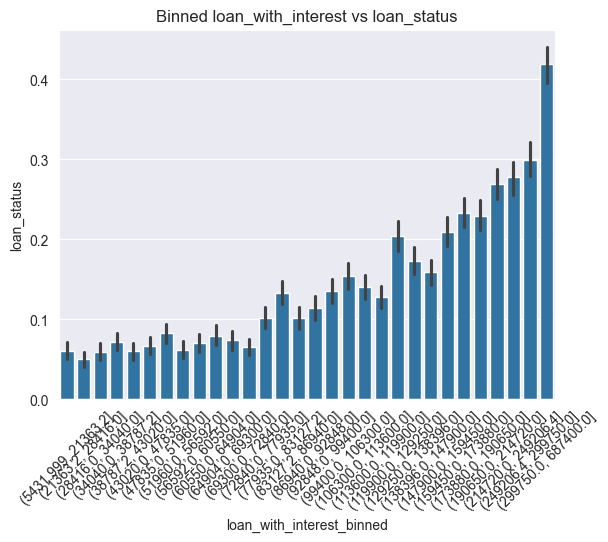

In [253]:
data['loan_with_interest'] = data['loan_amnt']*(1+data['loan_int_rate'])
visualize_barplot_2(['loan_with_interest'],data)

Let's encode non-numerical columns:

In [232]:
data = pd.get_dummies(data, columns=['person_home_ownership'])
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].replace({'N':0,'Y':1})
print(data.head())

    person_age  person_income  person_emp_length loan_intent loan_grade  \
id                                                                        
0           37          35000                0.0   EDUCATION          B   
1           22          56000                6.0     MEDICAL          C   
2           29          28800                8.0    PERSONAL          A   
3           30          70000               14.0     VENTURE          B   
4           22          60000                2.0     MEDICAL          A   

    loan_amnt  loan_int_rate  loan_percent_income  cb_person_default_on_file  \
id                                                                             
0        6000       2.441477            -1.771957                          0   
1        4000       2.591516            -2.659260                          0   
2        6000       2.186051            -1.560648                          0   
3       12000       2.407846            -1.771957                         

C:\Users\piecz\AppData\Local\Temp\ipykernel_24588\4000074389.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['cb_person_default_on_file'] = data['cb_person_default_on_file'].replace({'N':0,'Y':1})


In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('loan_status',axis=1),data['loan_status'],test_size=0.2, random_state=42)

from category_encoders import MEstimateEncoder
encoder = MEstimateEncoder(cols=['loan_intent','loan_grade'],m=5.0)
encoder.fit(X_train,y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

Let's score ouer data:

In [236]:
print(score(X_train,y_train,X_test,y_test))

Class 0
Accuracy :  0.6879529371642936
Recall   :  0.67512640031724
Precision:  0.9467537884053941
F1_score:  0.7881944444444444
Class 1
Accuracy :  0.6879529371642936
Recall   :  0.7667478684531059
Precision:  0.2775573192239859
F1_score:  0.40757526707672387
Roc auc score:
0.8114431848520791
[[6810 3277]
 [ 383 1259]]


C:\Users\piecz\PycharmProjects\pythonProject2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Outliers removal:


In [249]:
cols = ['person_income', 'person_age']
quantile0 = X_train[cols[0]].quantile(0.95)
quantile1 = X_train[cols[1]].quantile(0.99)

mask = (X_train['person_income'] <= quantile0) & (X_train['person_age'] <= quantile1)
X_train = X_train[mask]
y_train = y_train[mask]

print(X_train.describe().T)

                              count          mean           std          min  \
person_age                  44240.0     27.198056      5.353657    20.000000   
person_income               44240.0  59011.243422  23061.131441  4200.000000   
person_emp_length           44240.0      4.634652      3.859422     0.000000   
loan_intent                 44240.0      0.142947      0.036684     0.092040   
loan_grade                  44240.0      0.143208      0.161517     0.049524   
loan_amnt                   44240.0   8940.073508   5312.206794   500.000000   
loan_int_rate               44240.0      2.326680      0.296877     1.690096   
loan_percent_income         44240.0     -1.994727      0.625242    -4.605170   
cb_person_default_on_file   44240.0      0.150136      0.357208     0.000000   
cb_person_cred_hist_length  44240.0      5.604702      3.646626     2.000000   

                                     25%           50%           75%  \
person_age                     23.000000     26

Data normalization:

In [250]:
X_train_normalized = (X_train - X_train.mean()) / X_train.std()
X_test_normalized = (X_test - X_train.mean()) / X_train.std()
X_train= X_train_normalized
X_test = X_test_normalized

print(score(X_train,y_train,X_test,y_test))

Class 0
Accuracy :  0.8286298917213744
Recall   :  0.8273024685238426
Precision:  0.9688842447463137
F1_score:  0.8925133689839572
Class 1
Accuracy :  0.8286298917213744
Recall   :  0.8367844092570037
Precision:  0.44094993581514763
F1_score:  0.5775535939470365
Roc auc score:
0.902012720754527
[[8345 1742]
 [ 268 1374]]


training and tuning model

In [251]:
clf = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.01)
clf.fit(X_train,y_train)

print(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
    

0.9453342702894079
